Imports

In [ ]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

Constants

In [ ]:
img_width = 32

In [ ]:
args={}
kwargs={}

args['image_size'] = img_width*img_width  #Number of features in the input image
args['channels'] = 3  #Number of color channels for each image(3 usually for RGB)
args['batch_size']=32  #Number of samples in each batch
args['epochs']=80  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=1e-2  #Learning rate is how fast it will decend. 

args['cuda']=True  #Use GPU or not

In [ ]:
lossFn = nn.NLLLoss()
eps, beta = 0.1, 4

Load CIFAR10 Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args['batch_size'],
                                          shuffle=True, num_workers=2)

validation_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=args['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


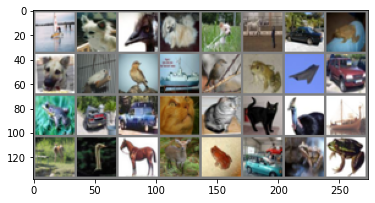

ship  dog   bird  dog   dog   horse car   frog  dog   bird  bird  ship  bird  frog  plane car   frog  car   car   cat   cat   cat   bird  ship  deer  bird  horse deer  frog  car   frog  frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(args['batch_size'])))


In [ ]:
# check if CUDA is available(CIFAR10 takes very long time to train)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if train_on_gpu else 'cpu')

CUDA is available!  Training on GPU ...


In [ ]:
def train(model, epoch, train_loader, lossFn, optimizer):

  model.train()
  running_loss = 0.0
  samples = 0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
     
    inputs, labels = inputs.to(device), labels.to(device)
    
    samples += len(inputs)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = lossFn(outputs, labels)

    # backpropagation
    loss.backward()

    # optimize parameters
    optimizer.step()

    running_loss += loss.data

  # print statistics
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, samples, len(train_loader.dataset),
            100. * batch_idx / len(train_loader), running_loss/len(train_loader)))

def validate(model, validation_loader, lossFn):
  correct = 0
  total = 0
  validation_loss = 0
  model.eval()

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for inputs, labels in validation_loader:

      inputs, labels = inputs.to(device), labels.to(device)

      # calculate outputs by running images through the network
      outputs = model(inputs)

      # Calculate loss
      validation_loss += lossFn(outputs, labels).data.item()

      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      
      total += labels.size(0)
      correct += (predicted == labels).sum().item()  #find number of correct predictions

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss/len(validation_loader), correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

ReLU

In [ ]:
class Conv4Relu(nn.Module):

  def __init__(self, image_size, channels):

    super(Conv4Relu, self).__init__()

    #Build a Vanilla ConvNet
    self.C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.F = nn.Flatten()
    self.D1 = nn.Linear(image_size*128, 256)
    self.D2 = nn.Linear(256, 256)

    #Output
    self.outputs = nn.Linear(256, 10)

  def forward(self, x):

    Z = F.relu(self.C1(x))
    Z = F.relu(self.C2(Z))
    Z = F.relu(self.C3(Z))
    Z = F.relu(self.C4(Z))

    Z = self.F(Z)

    Z = F.relu(self.D1(Z))
    Z = F.relu(self.D2(Z))

    return F.log_softmax(self.outputs(Z))

In [ ]:
relu_model = Conv4Relu(args['image_size'], args['channels'])
relu_model.to(device)
relu_model

Conv4Relu(
  (C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (F): Flatten(start_dim=1, end_dim=-1)
  (D1): Linear(in_features=131072, out_features=256, bias=True)
  (D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
optimizer = optim.SGD(relu_model.parameters(), lr=args['lr'])

In [ ]:
for epoch in range(1, args['epochs']+1):
  train(relu_model, epoch, train_loader, lossFn, optimizer)
  validate(relu_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.927200

Validation set: Average loss: 1.6206, Accuracy: 4232/10000 (42%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.497743

Validation set: Average loss: 1.4256, Accuracy: 4947/10000 (49%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.308422

Validation set: Average loss: 1.3530, Accuracy: 5245/10000 (52%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 1.161742

Validation set: Average loss: 1.1726, Accuracy: 5804/10000 (58%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 1.035623

Validation set: Average loss: 1.1067, Accuracy: 6087/10000 (61%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.911908

Validation set: Average loss: 1.0452, Accuracy: 6321/10000 (63%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.783226

Validation set: Average loss: 1.2041, Accuracy: 6010/10000 (60%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.650782

Validation set: Average loss: 1.0707, Accuracy: 6373/10000 (64%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.503696

Vali

DGN with ReLU activation for NPF

Decoupled learning with Soft ReLU activation

In [ ]:
class SoftGate(nn.Module):
  def __init__(self, **kwargs):
    super(SoftGate, self).__init__()

  def build(self, input_shape):
    super(SoftGate, self).build(input_shape)  

  def forward(self, x):
    activation = (1 + eps)*F.sigmoid(beta*x)
    return activation

  def compute_output_shape(self, input_shape):
    return input_shape

In [ ]:
class Conv4SoftGalu(nn.Module):

  def __init__(self, image_size, channels):
      
    super(Conv4SoftGalu, self).__init__()

    #NPF network
    self.NPF_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPF_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.NPF_F = nn.Flatten()
    self.NPF_D1 = nn.Linear(image_size*128, 256)
    self.NPF_D2 = nn.Linear(256, 256)

    #NPV Network
    self.NPV_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPV_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    self.NPV_F = nn.Flatten()
    self.NPV_D1 = nn.Linear(image_size*128, 256)
    self.NPV_D2 = nn.Linear(256, 256)
    self.outputs = nn.Linear(256, 10)

    
  def forward(self, x):

    # Calculate pre-activations(Qfi) and activations(Zfi) for NPF network
    Qf1 = self.NPF_C1(x)  
    Zf1 = F.relu(Qf1)
    Qf2 = self.NPF_C2(Zf1)
    Zf2 = F.relu(Qf2)
    Qf3 = self.NPF_C3(Zf2)
    Zf3 = F.relu(Qf3)
    Qf4 = self.NPF_C4(Zf3)
    Zf4 = F.relu(Qf4)

    Zf4 = self.NPF_F(Zf4)
    Qf5 = self.NPF_D1(Zf4)
    Zf5 = F.relu(Qf5)
    Qf6 = self.NPF_D2(Zf5)

    # Gating values
    G1 = SoftGate()(Qf1)
    G2 = SoftGate()(Qf2)
    G3 = SoftGate()(Qf3)
    G4 = SoftGate()(Qf4)
    G5 = SoftGate()(Qf5)
    G6 = SoftGate()(Qf6)

    # Calculate pre-activations(Qvi) and activations(Zvi) for NPV network
    Qv1 = self.NPV_C1(x)
    Zv1 = torch.mul(G1, Qv1)
    Qv2 = self.NPV_C2(Zv1)
    Zv2 = torch.mul(G2, Qv2)
    Qv3 = self.NPV_C3(Zv2)
    Zv3 = torch.mul(G3, Qv3)
    Qv4 = self.NPV_C4(Zv3)
    Zv4 = torch.mul(G4, Qv4)

    Zv4 = self.NPV_F(Zv4)
    Qv5 = self.NPV_D1(Zv4)
    Zv5 = torch.mul(G5, Qv5)
    Qv6 = self.NPV_D2(Zv5)
    Zv6 = torch.mul(G6, Qv6)

    return F.log_softmax(self.outputs(Zv6))

In [ ]:
decoupled_soft_relu_model = Conv4SoftGalu(args['image_size'], args['channels'])
decoupled_soft_relu_model.to(device)
decoupled_soft_relu_model

Conv4SoftGalu(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear

In [ ]:
optimizer = optim.SGD(decoupled_soft_relu_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(decoupled_soft_relu_model, epoch, train_loader, lossFn, optimizer)
  validate(decoupled_soft_relu_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 2.151316

Validation set: Average loss: 1.8115, Accuracy: 3666/10000 (37%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.610187

Validation set: Average loss: 1.5020, Accuracy: 4694/10000 (47%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.405864

Validation set: Average loss: 1.3950, Accuracy: 5042/10000 (50%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 1.273511

Validation set: Average loss: 1.2656, Accuracy: 5499/10000 (55%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 1.155720

Validation set: Average loss: 1.2037, Accuracy: 5801/10000 (58%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 1.041662

Validation set: Average loss: 1.1218, Accuracy: 5988/10000 (60%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.922955

Validation set: Average loss: 1.1044, Accuracy: 6101/10000 (61%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.785313

Validation set: Average loss: 1.0849, Accuracy: 6371/10000 (64%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.633125

Vali

In [ ]:
class SignGate(nn.Module):
  def __init__(self, **kwargs):
    super(SignGate, self).__init__()

  def build(self, input_shape):
    super(SignGate, self).build(input_shape)  

  def forward(self, x):
    output = torch.sign(F.relu(x))
    return output

  def compute_output_shape(self, input_shape):
    return input_shape

In [ ]:
SignGate()(F.relu(torch.Tensor([-2, -1.1, 0, 5.6, -4.5, -0.2, 0.8])))

tensor([0., 0., 0., 1., 0., 0., 1.])

In [ ]:
class Conv4Galu(nn.Module):

  def __init__(self, image_size, channels):
    
    super(Conv4Galu, self).__init__()

    # NPF Network
    self.NPF_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPF_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.NPF_F = nn.Flatten()
    self.NPF_D1 = nn.Linear(image_size*128, 256)
    self.NPF_D2 = nn.Linear(256, 256)


    # NPV Network
    self.NPV_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPV_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    
    self.NPV_F = nn.Flatten()
    self.NPV_D1 = nn.Linear(image_size*128, 256)
    self.NPV_D2 = nn.Linear(256, 256)

    self.outputs = nn.Linear(256, 10)

  def forward(self, x):

    # Calculate pre-activations(Qfi) and activations(Zfi) for NPF network
    Zf1 = F.relu(self.NPF_C1(x))
    Zf2 = F.relu(self.NPF_C2(Zf1))
    Zf3 = F.relu(self.NPF_C3(Zf2))
    Zf4 = F.relu(self.NPF_C4(Zf3))

    Zf4_ = self.NPF_F(Zf4)
    Zf5 = F.relu(self.NPF_D1(Zf4_))
    Zf6 = F.relu(self.NPF_D2(Zf5))

    # Gating values
    G1 = SignGate()(Zf1)
    G2 = SignGate()(Zf2)
    G3 = SignGate()(Zf3)
    G4 = SignGate()(Zf4)
    G5 = SignGate()(Zf5)
    G6 = SignGate()(Zf6)

    # Calculate pre-activations(Qvi) and activations(Zvi) for NPV network

    Qv1 = self.NPV_C1(x)
    Zv1 = torch.mul(G1, Qv1)
    Qv2 = self.NPV_C2(Zv1)
    Zv2 = torch.mul(G2, Qv2)
    Qv3 = self.NPV_C3(Zv2)
    Zv3 = torch.mul(G3, Qv3)
    Qv4 = self.NPV_C4(Zv3)

    # print(Qv4.size(), G4.size())

    Zv4 = torch.mul(G4, Qv4)

    Zv4 = self.NPV_F(Zv4)
    Qv5 = self.NPV_D1(Zv4)
    Zv5 = torch.mul(G5, Qv5)
    Qv6 = self.NPV_D2(Zv5)
    Zv6 = torch.mul(G6, Qv6)

    return F.log_softmax(self.outputs(Zv6))

Decoupled Learning with hard relu

In [ ]:
decoupled_hard_relu_model = Conv4Galu(args['image_size'], args['channels'])
decoupled_hard_relu_model.to(device)
decoupled_hard_relu_model

Conv4Galu(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_

In [ ]:
optimizer = optim.SGD(decoupled_hard_relu_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(decoupled_hard_relu_model, epoch, train_loader, lossFn, optimizer)
  validate(decoupled_hard_relu_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.901805

Validation set: Average loss: 1.5688, Accuracy: 4326/10000 (43%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.391816

Validation set: Average loss: 1.3241, Accuracy: 5213/10000 (52%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.153991

Validation set: Average loss: 1.2211, Accuracy: 5584/10000 (56%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.927972

Validation set: Average loss: 1.2981, Accuracy: 5570/10000 (56%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.632888

Validation set: Average loss: 1.4499, Accuracy: 5521/10000 (55%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.306870

Validation set: Average loss: 2.0554, Accuracy: 5308/10000 (53%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.147833

Validation set: Average loss: 2.1565, Accuracy: 5576/10000 (56%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.083732

Validation set: Average loss: 2.7163, Accuracy: 5586/10000 (56%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.060095

Vali

FRNPF(II)

In [ ]:
frnpf_ii_model = Conv4Galu(args['image_size'], args['channels'])
frnpf_ii_model.to(device)
frnpf_ii_model

Conv4Galu(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_

In [ ]:
for name, param in frnpf_ii_model.named_parameters():
  if name[0:3]=='NPF':
    param.requires_grad = False

In [ ]:
for name, param in frnpf_ii_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(frnpf_ii_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(frnpf_ii_model, epoch, train_loader, lossFn, optimizer)
  validate(frnpf_ii_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.898570

Validation set: Average loss: 1.5425, Accuracy: 4475/10000 (45%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.403471

Validation set: Average loss: 1.4165, Accuracy: 5048/10000 (50%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.166733

Validation set: Average loss: 1.2674, Accuracy: 5505/10000 (55%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.927989

Validation set: Average loss: 1.2580, Accuracy: 5616/10000 (56%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.619012

Validation set: Average loss: 1.4655, Accuracy: 5521/10000 (55%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.297060

Validation set: Average loss: 1.9188, Accuracy: 5407/10000 (54%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.148777

Validation set: Average loss: 2.5157, Accuracy: 5145/10000 (51%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.088980

Validation set: Average loss: 2.6831, Accuracy: 5454/10000 (55%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.056636

Vali

FRNPF(DI)

In [ ]:
frnpf_di_model = Conv4Galu(args['image_size'], args['channels'])
frnpf_di_model.to(device)
frnpf_di_model

Conv4Galu(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_

In [ ]:
for name, param in frnpf_di_model.named_parameters():
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[-0.0019,  0.0185, -0.1181],
          [ 0.1679, -0.0833,  0.1155],
          [ 0.1736,  0.0489,  0.1676]],

         [[-0.1057,  0.0603,  0.0241],
          [-0.1840,  0.0324, -0.1352],
          [-0.1487,  0.0581, -0.0167]],

         [[-0.1195, -0.1121, -0.0433],
          [-0.0900, -0.1721,  0.1814],
          [ 0.1073,  0.1085, -0.1574]]],


        [[[ 0.0981, -0.0385, -0.0231],
          [ 0.0371, -0.1603,  0.1794],
          [ 0.1700, -0.0906,  0.1851]],

         [[-0.0426, -0.1535, -0.0716],
          [ 0.0549, -0.1895,  0.1919],
          [ 0.1463,  0.0401, -0.0376]],

         [[ 0.1339,  0.1742,  0.0941],
          [ 0.0716,  0.1272, -0.0439],
          [-0.1876,  0.1524,  0.1535]]],


        [[[-0.0071, -0.1299,  0.0887],
          [-0.0907, -0.0325,  0.0181],
          [ 0.1828,  0.1630, -0.1769]],

         [[ 0.0117,  0.0538,  0.1873],
          [ 0.1240,  0.0830,  0.0821],
          [ 0.0004,  0.0901, -0.1896]],

        

In [ ]:
for name, param in frnpf_di_model.named_parameters():
  if name[0:3]=='NPF':
    paramName = "NPV"+name[3:]
    param.data = frnpf_di_model.state_dict().get(paramName).data.detach().clone()
    param.requires_grad = False
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.1702, -0.0410, -0.1715],
          [-0.1727, -0.1691,  0.1663],
          [-0.0101, -0.1337,  0.0772]],

         [[ 0.0743,  0.1482,  0.0419],
          [ 0.1614,  0.1694,  0.1859],
          [-0.1185, -0.0738,  0.0040]],

         [[ 0.0363, -0.0772, -0.1612],
          [ 0.0859,  0.0229,  0.0993],
          [ 0.0268, -0.1790,  0.1827]]],


        [[[ 0.1779, -0.1019, -0.1768],
          [-0.1688,  0.0673,  0.0757],
          [ 0.1021,  0.0230,  0.0172]],

         [[-0.1060,  0.0220,  0.0491],
          [ 0.0193,  0.0763, -0.0260],
          [-0.0401, -0.1085, -0.0292]],

         [[-0.0725,  0.0668,  0.0805],
          [ 0.0910, -0.0254,  0.0105],
          [-0.1620, -0.1402,  0.1393]]],


        [[[-0.1743, -0.1056,  0.0858],
          [ 0.1476, -0.0166, -0.0909],
          [ 0.1034, -0.1136, -0.0495]],

         [[-0.1307,  0.1124, -0.0006],
          [-0.0614,  0.1173, -0.1692],
          [-0.0389,  0.1868,  0.0260]],

        

In [ ]:
for name, param in frnpf_di_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(frnpf_di_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(frnpf_di_model, epoch, train_loader, lossFn, optimizer)
  validate(frnpf_di_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.984891

Validation set: Average loss: 1.6055, Accuracy: 4153/10000 (42%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.444672

Validation set: Average loss: 1.4728, Accuracy: 4865/10000 (49%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.227002

Validation set: Average loss: 1.2453, Accuracy: 5552/10000 (56%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 1.032156

Validation set: Average loss: 1.2242, Accuracy: 5667/10000 (57%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.792091

Validation set: Average loss: 1.3614, Accuracy: 5497/10000 (55%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.474851

Validation set: Average loss: 1.6137, Accuracy: 5471/10000 (55%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.220017

Validation set: Average loss: 2.0530, Accuracy: 5441/10000 (54%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.118273

Validation set: Average loss: 2.5550, Accuracy: 5439/10000 (54%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.069813

Vali

In [ ]:
for name, param in frnpf_di_model.named_parameters():
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.1702, -0.0410, -0.1715],
          [-0.1727, -0.1691,  0.1663],
          [-0.0101, -0.1337,  0.0772]],

         [[ 0.0743,  0.1482,  0.0419],
          [ 0.1614,  0.1694,  0.1859],
          [-0.1185, -0.0738,  0.0040]],

         [[ 0.0363, -0.0772, -0.1612],
          [ 0.0859,  0.0229,  0.0993],
          [ 0.0268, -0.1790,  0.1827]]],


        [[[ 0.1779, -0.1019, -0.1768],
          [-0.1688,  0.0673,  0.0757],
          [ 0.1021,  0.0230,  0.0172]],

         [[-0.1060,  0.0220,  0.0491],
          [ 0.0193,  0.0763, -0.0260],
          [-0.0401, -0.1085, -0.0292]],

         [[-0.0725,  0.0668,  0.0805],
          [ 0.0910, -0.0254,  0.0105],
          [-0.1620, -0.1402,  0.1393]]],


        [[[-0.1743, -0.1056,  0.0858],
          [ 0.1476, -0.0166, -0.0909],
          [ 0.1034, -0.1136, -0.0495]],

         [[-0.1307,  0.1124, -0.0006],
          [-0.0614,  0.1173, -0.1692],
          [-0.0389,  0.1868,  0.0260]],

        

In [ ]:
frnpf_di_model.state_dict().get("NPV_C1.weight").data

tensor([[[[ 0.1586, -0.0621, -0.1892],
          [-0.1834, -0.1902,  0.1383],
          [-0.0405, -0.1706,  0.0259]],

         [[ 0.0793,  0.1458,  0.0343],
          [ 0.1796,  0.1783,  0.1766],
          [-0.1248, -0.0864, -0.0336]],

         [[ 0.0238, -0.0957, -0.1886],
          [ 0.0946,  0.0240,  0.0776],
          [ 0.0128, -0.1983,  0.1339]]],


        [[[ 0.1717, -0.1048, -0.1650],
          [-0.1764,  0.0649,  0.0912],
          [ 0.0987,  0.0211,  0.0316]],

         [[-0.1169,  0.0198,  0.0652],
          [-0.0017,  0.0652, -0.0149],
          [-0.0634, -0.1268, -0.0268]],

         [[-0.0754,  0.0757,  0.1068],
          [ 0.0743, -0.0299,  0.0271],
          [-0.1845, -0.1561,  0.1426]]],


        [[[-0.1774, -0.1096,  0.0817],
          [ 0.1449, -0.0206, -0.0963],
          [ 0.1000, -0.1177, -0.0562]],

         [[-0.1334,  0.1086, -0.0048],
          [-0.0637,  0.1135, -0.1748],
          [-0.0421,  0.1827,  0.0190]],

         [[-0.0166, -0.0723,  0.0809],
     

In [ ]:
frnpf_di_model.state_dict().get("NPF_C1.weight").data

tensor([[[[ 0.1702, -0.0410, -0.1715],
          [-0.1727, -0.1691,  0.1663],
          [-0.0101, -0.1337,  0.0772]],

         [[ 0.0743,  0.1482,  0.0419],
          [ 0.1614,  0.1694,  0.1859],
          [-0.1185, -0.0738,  0.0040]],

         [[ 0.0363, -0.0772, -0.1612],
          [ 0.0859,  0.0229,  0.0993],
          [ 0.0268, -0.1790,  0.1827]]],


        [[[ 0.1779, -0.1019, -0.1768],
          [-0.1688,  0.0673,  0.0757],
          [ 0.1021,  0.0230,  0.0172]],

         [[-0.1060,  0.0220,  0.0491],
          [ 0.0193,  0.0763, -0.0260],
          [-0.0401, -0.1085, -0.0292]],

         [[-0.0725,  0.0668,  0.0805],
          [ 0.0910, -0.0254,  0.0105],
          [-0.1620, -0.1402,  0.1393]]],


        [[[-0.1743, -0.1056,  0.0858],
          [ 0.1476, -0.0166, -0.0909],
          [ 0.1034, -0.1136, -0.0495]],

         [[-0.1307,  0.1124, -0.0006],
          [-0.0614,  0.1173, -0.1692],
          [-0.0389,  0.1868,  0.0260]],

         [[-0.0134, -0.0680,  0.0858],
     

FLNPF

In [ ]:
flnpf_model = Conv4Galu(args['image_size'], args['channels'])
flnpf_model.to(device)
flnpf_model

Conv4Galu(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_

In [ ]:
for p in relu_model.parameters():
  print(p)

Parameter containing:
tensor([[[[ 0.3054,  0.3379,  0.2370],
          [-0.1890, -0.1106,  0.1405],
          [-0.0046, -0.4660, -0.2788]],

         [[ 0.2516,  0.3130,  0.1939],
          [-0.1023,  0.1089,  0.1193],
          [-0.2876, -0.1791, -0.3651]],

         [[ 0.0922,  0.3381,  0.2529],
          [ 0.0614,  0.2272, -0.0814],
          [-0.2718, -0.3674, -0.2690]]],


        [[[ 0.2009, -0.0522, -0.0179],
          [-0.0160, -0.1120,  0.1334],
          [-0.1376, -0.0971,  0.1453]],

         [[ 0.0248, -0.1657, -0.0605],
          [-0.1915, -0.2418, -0.1057],
          [ 0.0745, -0.0089,  0.1693]],

         [[-0.0560, -0.1588, -0.1330],
          [-0.0290, -0.2459, -0.0082],
          [-0.1343, -0.1229,  0.1984]]],


        [[[ 0.0337, -0.0086, -0.0188],
          [-0.1410, -0.0671,  0.0382],
          [ 0.0306, -0.0489,  0.1722]],

         [[-0.0487,  0.0578,  0.1902],
          [-0.0501,  0.1975,  0.1041],
          [ 0.0345, -0.1310,  0.0189]],

         [[-0.0790,  0

In [ ]:
trained_params = [x.data for x in relu_model.parameters()]

i=0
for (name, params) in flnpf_model.named_parameters():
  if name[0:3]=='NPF':
    params.data = trained_params[i]
    params.requires_grad = False
    i+=1
  print(name, params)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.3054,  0.3379,  0.2370],
          [-0.1890, -0.1106,  0.1405],
          [-0.0046, -0.4660, -0.2788]],

         [[ 0.2516,  0.3130,  0.1939],
          [-0.1023,  0.1089,  0.1193],
          [-0.2876, -0.1791, -0.3651]],

         [[ 0.0922,  0.3381,  0.2529],
          [ 0.0614,  0.2272, -0.0814],
          [-0.2718, -0.3674, -0.2690]]],


        [[[ 0.2009, -0.0522, -0.0179],
          [-0.0160, -0.1120,  0.1334],
          [-0.1376, -0.0971,  0.1453]],

         [[ 0.0248, -0.1657, -0.0605],
          [-0.1915, -0.2418, -0.1057],
          [ 0.0745, -0.0089,  0.1693]],

         [[-0.0560, -0.1588, -0.1330],
          [-0.0290, -0.2459, -0.0082],
          [-0.1343, -0.1229,  0.1984]]],


        [[[ 0.0337, -0.0086, -0.0188],
          [-0.1410, -0.0671,  0.0382],
          [ 0.0306, -0.0489,  0.1722]],

         [[-0.0487,  0.0578,  0.1902],
          [-0.0501,  0.1975,  0.1041],
          [ 0.0345, -0.1310,  0.0189]],

        

In [ ]:
for name, param in flnpf_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(flnpf_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(flnpf_model, epoch, train_loader, lossFn, optimizer)
  validate(flnpf_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.823352

Validation set: Average loss: 1.5129, Accuracy: 6236/10000 (62%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 0.241539

Validation set: Average loss: 1.8304, Accuracy: 6430/10000 (64%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 0.114915

Validation set: Average loss: 2.1921, Accuracy: 6453/10000 (65%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.048384

Validation set: Average loss: 2.8466, Accuracy: 6374/10000 (64%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.019138

Validation set: Average loss: 3.7696, Accuracy: 6516/10000 (65%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.012317

Validation set: Average loss: 4.2540, Accuracy: 6489/10000 (65%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.005762

Validation set: Average loss: 5.1602, Accuracy: 6468/10000 (65%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.002082

Validation set: Average loss: 5.3957, Accuracy: 6498/10000 (65%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.001424

Vali

DGN with Linear activation for NPF

Decoupled learning with Soft ReLU activation

In [ ]:
class Conv4SoftGaluLinear(nn.Module):

  def __init__(self, image_size, channels):
      
    super(Conv4SoftGaluLinear, self).__init__()

    #NPF network
    self.NPF_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPF_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.NPF_F = nn.Flatten()
    self.NPF_D1 = nn.Linear(image_size*128, 256)
    self.NPF_D2 = nn.Linear(256, 256)

    #NPV Network
    self.NPV_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPV_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    self.NPV_F = nn.Flatten()
    self.NPV_D1 = nn.Linear(image_size*128, 256)
    self.NPV_D2 = nn.Linear(256, 256)
    self.outputs = nn.Linear(256, 10)

    
  def forward(self, x):

    # Calculate pre-activations(Qfi) and activations(Zfi) for NPF network
    Zf1 = self.NPF_C1(x)  # Use linear activations(So Qf = Zf)
    Zf2 = self.NPF_C2(Zf1)
    Zf3 = self.NPF_C3(Zf2)
    Zf4 = self.NPF_C4(Zf3)

    Zf4_ = self.NPF_F(Zf4)
    Zf5 = self.NPF_D1(Zf4_)
    Zf6 = self.NPF_D2(Zf5)

    # Gating values
    G1 = SoftGate()(Zf1)
    G2 = SoftGate()(Zf2)
    G3 = SoftGate()(Zf3)
    G4 = SoftGate()(Zf4)
    G5 = SoftGate()(Zf5)
    G6 = SoftGate()(Zf6)

    # Calculate pre-activations(Qvi) and activations(Zvi) for NPV network
    Qv1 = self.NPV_C1(x)
    Zv1 = torch.mul(G1, Qv1)
    Qv2 = self.NPV_C2(Zv1)
    Zv2 = torch.mul(G2, Qv2)
    Qv3 = self.NPV_C3(Zv2)
    Zv3 = torch.mul(G3, Qv3)
    Qv4 = self.NPV_C4(Zv3)
    Zv4 = torch.mul(G4, Qv4)

    Zv4 = self.NPV_F(Zv4)
    Qv5 = self.NPV_D1(Zv4)
    Zv5 = torch.mul(G5, Qv5)
    Qv6 = self.NPV_D2(Zv5)
    Zv6 = torch.mul(G6, Qv6)

    return F.log_softmax(self.outputs(Zv6))

In [ ]:
decoupled_soft_relu_linear_model = Conv4SoftGaluLinear(args['image_size'], args['channels'])
decoupled_soft_relu_linear_model.to(device)
decoupled_soft_relu_linear_model

Conv4SoftGaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): 

In [ ]:
class Conv4SoftGaluLinear(nn.Module):

  def __init__(self, image_size, channels):
      
    super(Conv4SoftGaluLinear, self).__init__()
    self.i = 0

    #NPF network
    self.NPF_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPF_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.NPF_F = nn.Flatten()
    self.NPF_D1 = nn.Linear(image_size*128, 256)
    self.NPF_D2 = nn.Linear(256, 256)

    #NPV Network
    self.NPV_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPV_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    self.NPV_F = nn.Flatten()
    self.NPV_D1 = nn.Linear(image_size*128, 256)
    self.NPV_D2 = nn.Linear(256, 256)
    self.outputs = nn.Linear(256, 10)

    
  def forward(self, x):

    self.i += 1

    # Calculate pre-activations(Qfi) and activations(Zfi) for NPF network
    Zf1 = self.NPF_C1(x)  # Use linear activations(So Qf = Zf)
    Zf2 = self.NPF_C2(Zf1)
    Zf3 = self.NPF_C3(Zf2)
    Zf4 = self.NPF_C4(Zf3)

    Zf4_ = self.NPF_F(Zf4)
    Zf5 = self.NPF_D1(Zf4_)
    Zf6 = self.NPF_D2(Zf5)

    # Gating values
    G1 = SoftGate()(Zf1)
    G2 = SoftGate()(Zf2)
    G3 = SoftGate()(Zf3)
    G4 = SoftGate()(Zf4)
    G5 = SoftGate()(Zf5)
    G6 = SoftGate()(Zf6)

    # Calculate pre-activations(Qvi) and activations(Zvi) for NPV network
    Qv1 = self.NPV_C1(x)
    Zv1 = torch.mul(G1, Qv1)
    Qv2 = self.NPV_C2(Zv1)
    Zv2 = torch.mul(G2, Qv2)
    Qv3 = self.NPV_C3(Zv2)
    Zv3 = torch.mul(G3, Qv3)
    Qv4 = self.NPV_C4(Zv3)
    Zv4 = torch.mul(G4, Qv4)

    Zv4 = self.NPV_F(Zv4)
    Qv5 = self.NPV_D1(Zv4)
    Zv5 = torch.mul(G5, Qv5)
    Qv6 = self.NPV_D2(Zv5)
    Zv6 = torch.mul(G6, Qv6)

    Qv_output = self.outputs(Zv6)
 
    return F.log_softmax(Qv_output)

In [ ]:
decoupled_soft_relu_linear_model = Conv4SoftGaluLinear(args['image_size'], args['channels'])
decoupled_soft_relu_linear_model.to(device)
decoupled_soft_relu_linear_model

Conv4SoftGaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): 

In [ ]:
optimizer = optim.SGD(decoupled_soft_relu_linear_model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs']+1):
  train(decoupled_soft_relu_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(decoupled_soft_relu_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 2.070893

Validation set: Average loss: 1.6798, Accuracy: 3921/10000 (39%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.534020

Validation set: Average loss: 1.5009, Accuracy: 4677/10000 (47%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.362790

Validation set: Average loss: 1.3548, Accuracy: 5138/10000 (51%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 1.240822

Validation set: Average loss: 1.3133, Accuracy: 5283/10000 (53%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 1.131280

Validation set: Average loss: 1.2672, Accuracy: 5523/10000 (55%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 1.013499

Validation set: Average loss: 1.2660, Accuracy: 5610/10000 (56%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.892516

Validation set: Average loss: 1.1563, Accuracy: 5966/10000 (60%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.768359

Validation set: Average loss: 1.1408, Accuracy: 6061/10000 (61%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.643240

Vali

Reduced Learning Rate

In [ ]:
decoupled_soft_relu_linear_model = Conv4SoftGaluLinear(args['image_size'], args['channels'])
decoupled_soft_relu_linear_model.to(device)
decoupled_soft_relu_linear_model

Conv4SoftGaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): 

In [ ]:
optimizer = optim.SGD(decoupled_soft_relu_linear_model.parameters(), lr=5e-3)  # reduce learning rate to half
for epoch in range(1, args['epochs']+1):
  train(decoupled_soft_relu_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(decoupled_soft_relu_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 2.274788

Validation set: Average loss: 2.0741, Accuracy: 2705/10000 (27%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.766121

Validation set: Average loss: 1.6139, Accuracy: 4272/10000 (43%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.502716

Validation set: Average loss: 1.4493, Accuracy: 4889/10000 (49%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 1.361111

Validation set: Average loss: 1.3722, Accuracy: 5077/10000 (51%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 1.250576

Validation set: Average loss: 1.3322, Accuracy: 5280/10000 (53%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 1.150768

Validation set: Average loss: 1.2953, Accuracy: 5393/10000 (54%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 1.052761

Validation set: Average loss: 1.2901, Accuracy: 5541/10000 (55%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.952005

Validation set: Average loss: 1.2892, Accuracy: 5620/10000 (56%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.848894

Vali

GaLU Network

In [ ]:
class Conv4GaluLinear(nn.Module):

  def __init__(self, image_size, channels):
    
    super(Conv4GaluLinear, self).__init__()

    # NPF Network
    self.NPF_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPF_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPF_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3), padding = 'same')

    self.NPF_F = nn.Flatten()
    self.NPF_D1 = nn.Linear(image_size*128, 256)
    self.NPF_D2 = nn.Linear(256, 256)


    # NPV Network
    self.NPV_C1 = nn.Conv2d(channels, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C2 = nn.Conv2d(64, 64, kernel_size = (3, 3), padding = 'same')
    self.NPV_C3 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 'same')
    self.NPV_C4 = nn.Conv2d(128, 128, kernel_size = (3, 3),  padding = 'same')
    
    self.NPV_F = nn.Flatten()
    self.NPV_D1 = nn.Linear(image_size*128, 256)
    self.NPV_D2 = nn.Linear(256, 256)

    self.outputs = nn.Linear(256, 10)

  def forward(self, x):

    # Calculate pre-activations(Qfi) and activations(Zfi) for NPF network
    Zf1 = self.NPF_C1(x)  #Use lineat activations(So Qf = Zf)
    Zf2 = self.NPF_C2(Zf1)
    Zf3 = self.NPF_C3(Zf2)
    Zf4 = self.NPF_C4(Zf3)

    Zf4_ = self.NPF_F(Zf4)
    Zf5 = self.NPF_D1(Zf4_)
    Zf6 = self.NPF_D2(Zf5)

    # Gating values(use ReLU - converts negative numbers to 0, followed by Sign gate to find the gating values = 1 if Qf>0 and 0 otherwise)
    G1 = SignGate()(F.relu(Zf1))
    G2 = SignGate()(F.relu(Zf2))
    G3 = SignGate()(F.relu(Zf3))
    G4 = SignGate()(F.relu(Zf4))
    G5 = SignGate()(F.relu(Zf5))
    G6 = SignGate()(F.relu(Zf6))

    # Calculate pre-activations(Qvi) and activations(Zvi) for NPV network

    Qv1 = self.NPV_C1(x)
    Zv1 = torch.mul(G1, Qv1)
    Qv2 = self.NPV_C2(Zv1)
    Zv2 = torch.mul(G2, Qv2)
    Qv3 = self.NPV_C3(Zv2)
    Zv3 = torch.mul(G3, Qv3)
    Qv4 = self.NPV_C4(Zv3)

    # print(Qv4.size(), G4.size())

    Zv4 = torch.mul(G4, Qv4)

    Zv4 = self.NPV_F(Zv4)
    Qv5 = self.NPV_D1(Zv4)
    Zv5 = torch.mul(G5, Qv5)
    Qv6 = self.NPV_D2(Zv5)
    Zv6 = torch.mul(G6, Qv6)

    return F.log_softmax(self.outputs(Zv6))

Decoupled Learning with hard relu

In [ ]:
decoupled_hard_relu_linear_model = Conv4GaluLinear(args['image_size'], args['channels'])
decoupled_hard_relu_linear_model.to(device)
decoupled_hard_relu_linear_model

Conv4GaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Line

In [ ]:
optimizer = optim.SGD(decoupled_hard_relu_linear_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(decoupled_hard_relu_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(decoupled_hard_relu_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.943714

Validation set: Average loss: 1.5103, Accuracy: 4583/10000 (46%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.354597

Validation set: Average loss: 1.2697, Accuracy: 5497/10000 (55%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.042386

Validation set: Average loss: 1.2647, Accuracy: 5615/10000 (56%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.672963

Validation set: Average loss: 1.3810, Accuracy: 5618/10000 (56%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.271060

Validation set: Average loss: 1.8611, Accuracy: 5550/10000 (56%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.121320

Validation set: Average loss: 2.2932, Accuracy: 5654/10000 (57%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.068582

Validation set: Average loss: 2.8480, Accuracy: 5362/10000 (54%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.038305

Validation set: Average loss: 3.1458, Accuracy: 5476/10000 (55%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.023365

Vali

FRNPF(II)

In [ ]:
frnpf_ii_linear_model = Conv4GaluLinear(args['image_size'], args['channels'])
frnpf_ii_linear_model.to(device)
frnpf_ii_linear_model

Conv4GaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Line

In [ ]:
for name, param in frnpf_ii_linear_model.named_parameters():
  if name[0:3]=='NPF':
    param.requires_grad = False

In [ ]:
for name, param in frnpf_ii_linear_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(frnpf_ii_linear_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(frnpf_ii_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(frnpf_ii_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.921283

Validation set: Average loss: 1.5689, Accuracy: 4308/10000 (43%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.370443

Validation set: Average loss: 1.2888, Accuracy: 5383/10000 (54%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 1.080853

Validation set: Average loss: 1.2456, Accuracy: 5596/10000 (56%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.746084

Validation set: Average loss: 1.4407, Accuracy: 5390/10000 (54%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.351427

Validation set: Average loss: 1.6764, Accuracy: 5643/10000 (56%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.134558

Validation set: Average loss: 2.0811, Accuracy: 5742/10000 (57%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.071213

Validation set: Average loss: 2.6456, Accuracy: 5552/10000 (56%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.038876

Validation set: Average loss: 2.6487, Accuracy: 5612/10000 (56%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.032738

Vali

FRNPF(DI)

In [ ]:
frnpf_di_linear_model = Conv4GaluLinear(args['image_size'], args['channels'])
frnpf_di_linear_model.to(device)
frnpf_di_linear_model

Conv4GaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Line

In [ ]:
for name, param in frnpf_di_linear_model.named_parameters():
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[-0.1553,  0.1612, -0.1423],
          [ 0.0805,  0.0772, -0.1055],
          [-0.1493,  0.1051,  0.1707]],

         [[ 0.0159,  0.1586,  0.1776],
          [ 0.0674, -0.0341, -0.1590],
          [-0.1821,  0.0621,  0.0075]],

         [[-0.1605,  0.0590,  0.0632],
          [ 0.1709,  0.0633, -0.1144],
          [-0.0854, -0.1694,  0.1524]]],


        [[[-0.1911,  0.1477,  0.0673],
          [ 0.0684, -0.0258, -0.0104],
          [ 0.0230,  0.0514,  0.0629]],

         [[ 0.0406,  0.1005,  0.0801],
          [ 0.0922, -0.0430,  0.1127],
          [ 0.0451, -0.1351,  0.1666]],

         [[-0.0677, -0.0340, -0.1864],
          [ 0.0263,  0.0345, -0.1246],
          [ 0.0673, -0.0600, -0.1315]]],


        [[[-0.1219,  0.1154, -0.0051],
          [-0.0432, -0.0742, -0.1570],
          [ 0.0801, -0.1165, -0.1498]],

         [[-0.1570, -0.0557, -0.0677],
          [ 0.0273, -0.1159, -0.0053],
          [-0.0819,  0.1226, -0.0700]],

        

In [ ]:
for name, param in frnpf_di_linear_model.named_parameters():
  if name[0:3]=='NPF':
    paramName = "NPV"+name[3:]
    param.data = frnpf_di_linear_model.state_dict().get(paramName).data.detach().clone()
    param.requires_grad = False
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.1397,  0.1195,  0.1305],
          [-0.0399, -0.0212,  0.0863],
          [ 0.1052, -0.0467, -0.0340]],

         [[-0.0456, -0.0650,  0.1604],
          [-0.0800, -0.0553, -0.1571],
          [ 0.0502,  0.1586,  0.0630]],

         [[ 0.0627,  0.0695, -0.1562],
          [-0.0733,  0.0070,  0.0283],
          [ 0.0936,  0.0916,  0.1129]]],


        [[[ 0.0221,  0.0690, -0.1078],
          [-0.0679, -0.0322, -0.1376],
          [ 0.0458,  0.1631, -0.1905]],

         [[ 0.0455, -0.0057, -0.0026],
          [-0.0064, -0.0585, -0.0138],
          [ 0.0039,  0.1116, -0.1620]],

         [[-0.1902,  0.0577, -0.0802],
          [-0.1305,  0.0760,  0.1524],
          [ 0.0461,  0.0873,  0.1867]]],


        [[[-0.1342, -0.0936,  0.1755],
          [ 0.0561, -0.0583, -0.0318],
          [ 0.0938,  0.1439,  0.1216]],

         [[-0.1711, -0.0103, -0.1485],
          [-0.0844,  0.0103, -0.1425],
          [ 0.0812, -0.1875, -0.0808]],

        

In [ ]:
frnpf_di_linear_model.state_dict().get("NPV_C1.weight").data

tensor([[[[ 0.1397,  0.1195,  0.1305],
          [-0.0399, -0.0212,  0.0863],
          [ 0.1052, -0.0467, -0.0340]],

         [[-0.0456, -0.0650,  0.1604],
          [-0.0800, -0.0553, -0.1571],
          [ 0.0502,  0.1586,  0.0630]],

         [[ 0.0627,  0.0695, -0.1562],
          [-0.0733,  0.0070,  0.0283],
          [ 0.0936,  0.0916,  0.1129]]],


        [[[ 0.0221,  0.0690, -0.1078],
          [-0.0679, -0.0322, -0.1376],
          [ 0.0458,  0.1631, -0.1905]],

         [[ 0.0455, -0.0057, -0.0026],
          [-0.0064, -0.0585, -0.0138],
          [ 0.0039,  0.1116, -0.1620]],

         [[-0.1902,  0.0577, -0.0802],
          [-0.1305,  0.0760,  0.1524],
          [ 0.0461,  0.0873,  0.1867]]],


        [[[-0.1342, -0.0936,  0.1755],
          [ 0.0561, -0.0583, -0.0318],
          [ 0.0938,  0.1439,  0.1216]],

         [[-0.1711, -0.0103, -0.1485],
          [-0.0844,  0.0103, -0.1425],
          [ 0.0812, -0.1875, -0.0808]],

         [[-0.0108,  0.0017, -0.1373],
     

In [ ]:
frnpf_di_linear_model.state_dict().get("NPF_C1.weight").data

tensor([[[[ 0.1397,  0.1195,  0.1305],
          [-0.0399, -0.0212,  0.0863],
          [ 0.1052, -0.0467, -0.0340]],

         [[-0.0456, -0.0650,  0.1604],
          [-0.0800, -0.0553, -0.1571],
          [ 0.0502,  0.1586,  0.0630]],

         [[ 0.0627,  0.0695, -0.1562],
          [-0.0733,  0.0070,  0.0283],
          [ 0.0936,  0.0916,  0.1129]]],


        [[[ 0.0221,  0.0690, -0.1078],
          [-0.0679, -0.0322, -0.1376],
          [ 0.0458,  0.1631, -0.1905]],

         [[ 0.0455, -0.0057, -0.0026],
          [-0.0064, -0.0585, -0.0138],
          [ 0.0039,  0.1116, -0.1620]],

         [[-0.1902,  0.0577, -0.0802],
          [-0.1305,  0.0760,  0.1524],
          [ 0.0461,  0.0873,  0.1867]]],


        [[[-0.1342, -0.0936,  0.1755],
          [ 0.0561, -0.0583, -0.0318],
          [ 0.0938,  0.1439,  0.1216]],

         [[-0.1711, -0.0103, -0.1485],
          [-0.0844,  0.0103, -0.1425],
          [ 0.0812, -0.1875, -0.0808]],

         [[-0.0108,  0.0017, -0.1373],
     

In [ ]:
for name, param in frnpf_di_linear_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(frnpf_di_linear_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(frnpf_di_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(frnpf_di_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.885032

Validation set: Average loss: 1.5352, Accuracy: 4478/10000 (45%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.333674

Validation set: Average loss: 1.2499, Accuracy: 5542/10000 (55%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 0.989346

Validation set: Average loss: 1.3190, Accuracy: 5454/10000 (55%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.591081

Validation set: Average loss: 1.6057, Accuracy: 5269/10000 (53%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.214186

Validation set: Average loss: 1.7900, Accuracy: 5575/10000 (56%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.099109

Validation set: Average loss: 2.4918, Accuracy: 5549/10000 (55%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.053100

Validation set: Average loss: 2.7466, Accuracy: 5578/10000 (56%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.042352

Validation set: Average loss: 2.6702, Accuracy: 5794/10000 (58%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.024358

Vali

In [ ]:
for name, param in frnpf_di_linear_model.named_parameters():
  print(name, param)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.1397,  0.1195,  0.1305],
          [-0.0399, -0.0212,  0.0863],
          [ 0.1052, -0.0467, -0.0340]],

         [[-0.0456, -0.0650,  0.1604],
          [-0.0800, -0.0553, -0.1571],
          [ 0.0502,  0.1586,  0.0630]],

         [[ 0.0627,  0.0695, -0.1562],
          [-0.0733,  0.0070,  0.0283],
          [ 0.0936,  0.0916,  0.1129]]],


        [[[ 0.0221,  0.0690, -0.1078],
          [-0.0679, -0.0322, -0.1376],
          [ 0.0458,  0.1631, -0.1905]],

         [[ 0.0455, -0.0057, -0.0026],
          [-0.0064, -0.0585, -0.0138],
          [ 0.0039,  0.1116, -0.1620]],

         [[-0.1902,  0.0577, -0.0802],
          [-0.1305,  0.0760,  0.1524],
          [ 0.0461,  0.0873,  0.1867]]],


        [[[-0.1342, -0.0936,  0.1755],
          [ 0.0561, -0.0583, -0.0318],
          [ 0.0938,  0.1439,  0.1216]],

         [[-0.1711, -0.0103, -0.1485],
          [-0.0844,  0.0103, -0.1425],
          [ 0.0812, -0.1875, -0.0808]],

        

In [ ]:
frnpf_di_linear_model.state_dict().get("NPV_C1.weight").data

tensor([[[[ 0.1439,  0.1235,  0.1334],
          [-0.0367, -0.0182,  0.0882],
          [ 0.1098, -0.0423, -0.0311]],

         [[-0.0388, -0.0585,  0.1656],
          [-0.0744, -0.0497, -0.1528],
          [ 0.0572,  0.1653,  0.0680]],

         [[ 0.0709,  0.0773, -0.1499],
          [-0.0665,  0.0137,  0.0337],
          [ 0.1010,  0.0986,  0.1184]]],


        [[[ 0.0253,  0.0712, -0.1079],
          [-0.0650, -0.0289, -0.1373],
          [ 0.0572,  0.1747, -0.1841]],

         [[ 0.0453, -0.0063, -0.0051],
          [-0.0063, -0.0573, -0.0153],
          [ 0.0129,  0.1215, -0.1573]],

         [[-0.1953,  0.0528, -0.0865],
          [-0.1359,  0.0722,  0.1463],
          [ 0.0488,  0.0912,  0.1857]]],


        [[[-0.1279, -0.1052,  0.1603],
          [ 0.0498, -0.0874, -0.0633],
          [ 0.0945,  0.1263,  0.1028]],

         [[-0.1742, -0.0347, -0.1759],
          [-0.0940, -0.0251, -0.1792],
          [ 0.0867, -0.2025, -0.0961]],

         [[-0.0320, -0.0412, -0.1846],
     

In [ ]:
frnpf_di_linear_model.state_dict().get("NPF_C1.weight").data

tensor([[[[ 0.1397,  0.1195,  0.1305],
          [-0.0399, -0.0212,  0.0863],
          [ 0.1052, -0.0467, -0.0340]],

         [[-0.0456, -0.0650,  0.1604],
          [-0.0800, -0.0553, -0.1571],
          [ 0.0502,  0.1586,  0.0630]],

         [[ 0.0627,  0.0695, -0.1562],
          [-0.0733,  0.0070,  0.0283],
          [ 0.0936,  0.0916,  0.1129]]],


        [[[ 0.0221,  0.0690, -0.1078],
          [-0.0679, -0.0322, -0.1376],
          [ 0.0458,  0.1631, -0.1905]],

         [[ 0.0455, -0.0057, -0.0026],
          [-0.0064, -0.0585, -0.0138],
          [ 0.0039,  0.1116, -0.1620]],

         [[-0.1902,  0.0577, -0.0802],
          [-0.1305,  0.0760,  0.1524],
          [ 0.0461,  0.0873,  0.1867]]],


        [[[-0.1342, -0.0936,  0.1755],
          [ 0.0561, -0.0583, -0.0318],
          [ 0.0938,  0.1439,  0.1216]],

         [[-0.1711, -0.0103, -0.1485],
          [-0.0844,  0.0103, -0.1425],
          [ 0.0812, -0.1875, -0.0808]],

         [[-0.0108,  0.0017, -0.1373],
     

FLNPF

In [ ]:
flnpf_linear_model = Conv4GaluLinear(args['image_size'], args['channels'])
flnpf_linear_model.to(device)
flnpf_linear_model

Conv4GaluLinear(
  (NPF_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPF_F): Flatten(start_dim=1, end_dim=-1)
  (NPF_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPF_D2): Linear(in_features=256, out_features=256, bias=True)
  (NPV_C1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_C4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (NPV_F): Flatten(start_dim=1, end_dim=-1)
  (NPV_D1): Linear(in_features=131072, out_features=256, bias=True)
  (NPV_D2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Line

In [ ]:
for p in relu_model.parameters():
  print(p)

Parameter containing:
tensor([[[[ 0.1783,  0.1678,  0.0707],
          [-0.2148,  0.0080, -0.1329],
          [-0.0768, -0.0828,  0.1414]],

         [[ 0.1201,  0.1692, -0.0584],
          [ 0.1144, -0.0063,  0.0048],
          [ 0.0877, -0.2433, -0.2285]],

         [[ 0.1040,  0.0727,  0.2162],
          [-0.1520, -0.1024,  0.1551],
          [ 0.0867, -0.1389, -0.1641]]],


        [[[-0.1793, -0.1019, -0.0161],
          [-0.0146, -0.1024, -0.1758],
          [-0.1873, -0.0495, -0.2175]],

         [[-0.0260, -0.0427, -0.0657],
          [ 0.1340,  0.1662,  0.0424],
          [ 0.0282, -0.2293, -0.1476]],

         [[-0.0764,  0.1406,  0.2345],
          [-0.1003,  0.0475,  0.0635],
          [ 0.0049,  0.0302, -0.1059]]],


        [[[-0.0955, -0.0208, -0.1790],
          [ 0.0309, -0.1191, -0.1719],
          [ 0.2915, -0.0676, -0.0349]],

         [[-0.1897,  0.1271, -0.0343],
          [ 0.1399,  0.0184,  0.1888],
          [ 0.1491, -0.0418,  0.1892]],

         [[-0.1733, -0

In [ ]:
trained_params = [x.data for x in relu_model.parameters()]

i=0
for (name, params) in flnpf_linear_model.named_parameters():
  if name[0:3]=='NPF':
    params.data = trained_params[i]
    params.requires_grad = False
    i+=1
  print(name, params)

NPF_C1.weight Parameter containing:
tensor([[[[ 0.1783,  0.1678,  0.0707],
          [-0.2148,  0.0080, -0.1329],
          [-0.0768, -0.0828,  0.1414]],

         [[ 0.1201,  0.1692, -0.0584],
          [ 0.1144, -0.0063,  0.0048],
          [ 0.0877, -0.2433, -0.2285]],

         [[ 0.1040,  0.0727,  0.2162],
          [-0.1520, -0.1024,  0.1551],
          [ 0.0867, -0.1389, -0.1641]]],


        [[[-0.1793, -0.1019, -0.0161],
          [-0.0146, -0.1024, -0.1758],
          [-0.1873, -0.0495, -0.2175]],

         [[-0.0260, -0.0427, -0.0657],
          [ 0.1340,  0.1662,  0.0424],
          [ 0.0282, -0.2293, -0.1476]],

         [[-0.0764,  0.1406,  0.2345],
          [-0.1003,  0.0475,  0.0635],
          [ 0.0049,  0.0302, -0.1059]]],


        [[[-0.0955, -0.0208, -0.1790],
          [ 0.0309, -0.1191, -0.1719],
          [ 0.2915, -0.0676, -0.0349]],

         [[-0.1897,  0.1271, -0.0343],
          [ 0.1399,  0.0184,  0.1888],
          [ 0.1491, -0.0418,  0.1892]],

        

In [ ]:
for name, param in flnpf_linear_model.named_parameters():
  if param.requires_grad:
    print(name)

NPV_C1.weight
NPV_C1.bias
NPV_C2.weight
NPV_C2.bias
NPV_C3.weight
NPV_C3.bias
NPV_C4.weight
NPV_C4.bias
NPV_D1.weight
NPV_D1.bias
NPV_D2.weight
NPV_D2.bias
outputs.weight
outputs.bias


In [ ]:
optimizer = optim.SGD(flnpf_linear_model.parameters(), lr=args['lr'])
for epoch in range(1, args['epochs']+1):
  train(flnpf_linear_model, epoch, train_loader, lossFn, optimizer)
  validate(flnpf_linear_model, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.866728

Validation set: Average loss: 1.4675, Accuracy: 4684/10000 (47%)

Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.260146

Validation set: Average loss: 1.2232, Accuracy: 5583/10000 (56%)

Train Epoch: 3 [50000/50000 (100%)]	Loss: 0.934243

Validation set: Average loss: 1.1796, Accuracy: 5821/10000 (58%)

Train Epoch: 4 [50000/50000 (100%)]	Loss: 0.569756

Validation set: Average loss: 1.2849, Accuracy: 5996/10000 (60%)

Train Epoch: 5 [50000/50000 (100%)]	Loss: 0.220961

Validation set: Average loss: 1.8084, Accuracy: 5863/10000 (59%)

Train Epoch: 6 [50000/50000 (100%)]	Loss: 0.097999

Validation set: Average loss: 2.1656, Accuracy: 5773/10000 (58%)

Train Epoch: 7 [50000/50000 (100%)]	Loss: 0.056938

Validation set: Average loss: 2.4876, Accuracy: 5890/10000 (59%)

Train Epoch: 8 [50000/50000 (100%)]	Loss: 0.039705

Validation set: Average loss: 2.5050, Accuracy: 6083/10000 (61%)

Train Epoch: 9 [50000/50000 (100%)]	Loss: 0.019216

Vali